In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import re
import emoji
import nltk
from nltk.tokenize import word_tokenize
from textblob import TextBlob
import warnings 
warnings.filterwarnings('ignore')

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
CONFIG = {
    'test_size': 0.2,
    'random_state': 42,
    'tfidf_max_features': 30, 
    'ngram_range': (1, 2),
    'cv_folds': 5
}

for key, value in CONFIG.items():
    print(f"  {key}: {value}")

  test_size: 0.2
  random_state: 42
  tfidf_max_features: 30
  ngram_range: (1, 2)
  cv_folds: 5


Dataset shape: (11949, 3)
Columns: ['ID', 'comments', 'label']

 Null values:
ID          0
comments    0
label       0
dtype: int64

 Label distribution:
label
1    7898
0    4051
Name: count, dtype: int64


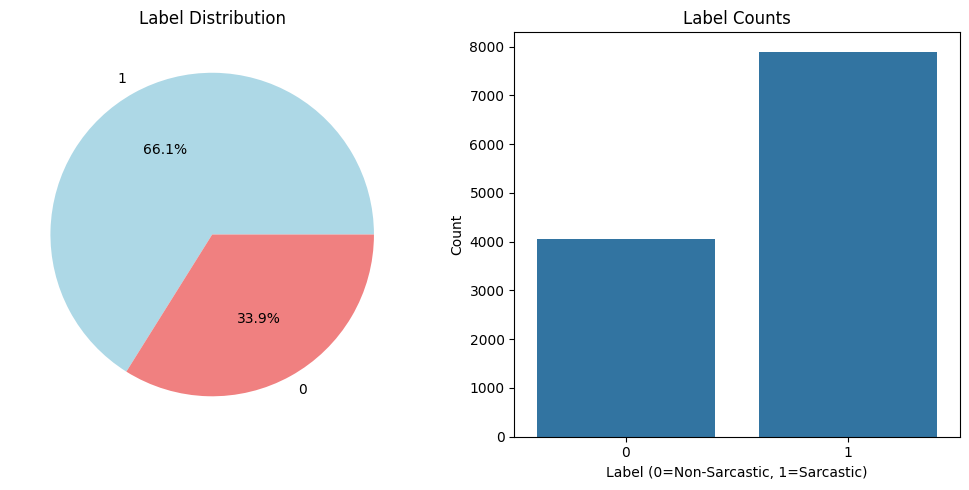

In [3]:
df = pd.read_csv('/teamspace/studios/this_studio/Sarcasm Detection/combined_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

print(f"\n Null values:")
print(df.isnull().sum())

# Basic info about the dataset
print(f"\n Label distribution:")
label_counts = df['label'].value_counts()
print(label_counts)

# Plot label distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
plt.title('Label Distribution')

plt.subplot(1, 2, 2)
sns.countplot(data=df, x='label')
plt.title('Label Counts')
plt.xlabel('Label (0=Non-Sarcastic, 1=Sarcastic)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [4]:
class TextPreprocessor:
    def __init__(self):
        self.hindi_stopwords = set(['hai', 'hain', 'ho', 'ka', 'ki', 'ko', 'se', 'mein', 'par', 'aur', 'yeh', 'woh'])
    
    def remove_urls(self, text):
        return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    def remove_mentions(self, text):
        return re.sub(r'@\w+', '', text)
    
    def remove_hashtags(self, text):
        return re.sub(r'#', '', text)
    
    def handle_emojis(self, text):
        return emoji.demojize(text, delimiters=(" ", " "))
    
    def normalize_elongations(self, text):
        return re.sub(r"(.)\1{3,}", r"\1\1\1", text)
    
    def clean_text(self, text):
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    def preprocess_text(self, text):
        if not isinstance(text, str):
            return ""
            
        text = self.remove_urls(text)
        text = self.remove_mentions(text)
        text = self.remove_hashtags(text)
        text = self.handle_emojis(text)
        text = self.normalize_elongations(text)
        text = text.lower()
        text = self.clean_text(text)
        return text

preprocessor = TextPreprocessor()
df['processed_text'] = df['comments'].apply(preprocessor.preprocess_text)

In [5]:
print("Text Statistics Analysis...")

df['text_length'] = df['processed_text'].apply(len)
df['word_count'] = df['processed_text'].apply(lambda x: len(x.split()))
from collections import Counter
all_words = ' '.join(df['processed_text']).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

words, counts = zip(*common_words)

print(f"Text Statistics Summary:")
print(f"Average text length: {df['text_length'].mean():.2f} characters")
print(f"Average word count: {df['word_count'].mean():.2f} words")
print(f"Max text length: {df['text_length'].max()} characters")
print(f"Min text length: {df['text_length'].min()} characters")

Text Statistics Analysis...
Text Statistics Summary:
Average text length: 80.13 characters
Average word count: 13.59 words
Max text length: 239 characters
Min text length: 6 characters


In [6]:
X = df['processed_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=CONFIG['test_size'], 
    random_state=CONFIG['random_state'],
    stratify=y
)

In [7]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=CONFIG['tfidf_max_features'],
    ngram_range=CONFIG['ngram_range'],
    stop_words='english',
    min_df=2, 
    max_df=0.8 
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"X_train_tfidf shape: {X_train_tfidf.shape}")
print(f"X_test_tfidf shape: {X_test_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

X_train_tfidf shape: (9559, 30)
X_test_tfidf shape: (2390, 30)
Vocabulary size: 30


In [ ]:
HINGLISH_FUNCTION_WORDS = [
    'accha', 'acha', 'kya', 'hai', 'hain', 'tha', 'thi',
    'ka', 'ki', 'ko', 'se', 'mein', 'me', 'par', 'toh', 'na'
]

HINGLISH_COLLOQS = [
    'bhai', 'yaar', 'sahi', 'mast', 'jhoot', 'sach', 'pyar', 'dost',
    'bakwaas', 'faltu', 'ghatiya'
]

SARCASM_PHRASES = [
    r'\bwah bhai wah\b',
    r'\bwah re wah\b',
    r'\bkya baat hai\b',
    r'\bbohot badiya\b',
    r'\btoo good\b',
    r'\bmaza aa gaya\b',
    r'\bhan han\b',
    r'\bthanks a lot\b',
    r'\bgreat service\b'
]

SINCERITY_PHRASES = [
    "sincerely appreciate",
    "truly appreciate",
    "thank you so much",
    "genuinely",
    "with gratitude"
]


POS_WORDS = ['great', 'awesome', 'amazing', 'nice', 'mast', 'sahi', 'accha', 'best']
NEG_WORDS = ['bakwaas', 'ghatiya', 'faltu', 'bad', 'worst', 'ghatiya', 'bekar', 'beqar']


def count_elongated(word):
    return 1 if re.search(r'(.)\1\1+', word) else 0
def extract_linguistic_features(texts):
    features = []

    for text in texts:
        feature_dict = {}
        t = str(text)
        tl = t.lower()

        feature_dict['text_length'] = len(t)
        tokens = re.findall(r"\w+", tl)
        feature_dict['word_count'] = len(tokens)

        feature_dict['exclamation_count'] = t.count('!')
        feature_dict['question_count'] = t.count('?')
        feature_dict['ellipsis_count'] = t.count('...')
        feature_dict['punctuation_density'] = sum(t.count(p) for p in '!?.,;:') / max(len(t), 1)

        feature_dict['uppercase_ratio'] = sum(1 for c in t if c.isupper()) / max(len(t), 1)

        emojis = ['😂', '😊', '😒', '🤣', '😭', '😡', '❤️', '✨', '🙃', '🤡']
        emoji_list = [c for c in t if c in emojis]
        feature_dict['emoji_count'] = len(emoji_list)
        feature_dict['neg_emoji_count'] = sum(c in ['😒', '😡', '🤡'] for c in emoji_list)
        feature_dict['pos_emoji_count'] = sum(c in ['😂', '😊', '🤣', '❤️', '✨', '🙃'] for c in emoji_list)

        try:
            blob = TextBlob(t)
            feature_dict['polarity'] = blob.sentiment.polarity
            feature_dict['subjectivity'] = blob.sentiment.subjectivity
        except:
            feature_dict['polarity'] = 0
            feature_dict['subjectivity'] = 0

        feature_dict['hinglish_function_count'] = sum(
            1 for w in tokens if w in HINGLISH_FUNCTION_WORDS
        )
        feature_dict['hinglish_colloq_count'] = sum(
            1 for w in tokens if w in HINGLISH_COLLOQS
        )

        sarcasm_hits = sum(len(re.findall(p, tl)) for p in SARCASM_PHRASES)
        feature_dict['sarcasm_phrase_count'] = sarcasm_hits
        feature_dict['has_sarcasm_phrase'] = int(sarcasm_hits > 0)

        feature_dict['elongated_word_count'] = sum(count_elongated(w) for w in tokens)
        feature_dict['multi_excl'] = len(re.findall(r'!!+', t))
        feature_dict['multi_ques'] = len(re.findall(r'\?\?+', t))

        feature_dict['pos_word_count'] = sum(w in POS_WORDS for w in tokens)
        feature_dict['neg_word_count'] = sum(w in NEG_WORDS for w in tokens)

        feature_dict['sincerity_phrase'] = int(
            any(p in tl for p in SINCERITY_PHRASES)
        )

        conflict = (
            (feature_dict['pos_word_count'] > 0 and feature_dict['neg_emoji_count'] > 0) or
            (feature_dict['neg_word_count'] > 0 and feature_dict['pos_emoji_count'] > 0) or
            (feature_dict['polarity'] > 0.2 and feature_dict['multi_ques'] > 0)
        )
        feature_dict['sentiment_conflict'] = int(conflict)

        features.append(feature_dict)

    return pd.DataFrame(features)


X_train_linguistic = extract_linguistic_features(X_train)
X_test_linguistic = extract_linguistic_features(X_test)

print(f"X_train_linguistic shape: {X_train_linguistic.shape}")
print(f"X_test_linguistic shape: {X_test_linguistic.shape}")
print(f"Linguistic features: {list(X_train_linguistic.columns)}")

X_train_linguistic shape: (9559, 23)
X_test_linguistic shape: (2390, 23)
Linguistic features: ['text_length', 'word_count', 'exclamation_count', 'question_count', 'ellipsis_count', 'punctuation_density', 'uppercase_ratio', 'emoji_count', 'neg_emoji_count', 'pos_emoji_count', 'polarity', 'subjectivity', 'hinglish_function_count', 'hinglish_colloq_count', 'sarcasm_phrase_count', 'has_sarcasm_phrase', 'elongated_word_count', 'multi_excl', 'multi_ques', 'pos_word_count', 'neg_word_count', 'sincerity_phrase', 'sentiment_conflict']


In [9]:
from scipy.sparse import hstack, csr_matrix

print("Combining TF-IDF and linguistic features...")

X_train_linguistic_sparse = csr_matrix(X_train_linguistic.values)
X_test_linguistic_sparse = csr_matrix(X_test_linguistic.values)

X_train_combined = hstack([X_train_tfidf, X_train_linguistic_sparse])
X_test_combined = hstack([X_test_tfidf, X_test_linguistic_sparse])

print(f"X_train_combined shape: {X_train_combined.shape}")
print(f"X_test_combined shape: {X_test_combined.shape}")

Combining TF-IDF and linguistic features...
X_train_combined shape: (9559, 53)
X_test_combined shape: (2390, 53)


In [10]:
models = {
    'Logistic Regression': LogisticRegression(
        random_state=CONFIG['random_state'],
        C=0.1, 
        max_iter=1000,
        class_weight='balanced' 
    ),
    'SVM': SVC(
        random_state=CONFIG['random_state'],
        C=0.1, 
        kernel='linear',
        probability=True,
        class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        random_state=CONFIG['random_state'],
        n_estimators=100,  
        max_depth=10, 
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced'
    )
}

Logistic Regression  | F1: 0.9642 (+/- 0.0071)
SVM                  | F1: 0.9644 (+/- 0.0057)
Random Forest        | F1: 0.9646 (+/- 0.0085)


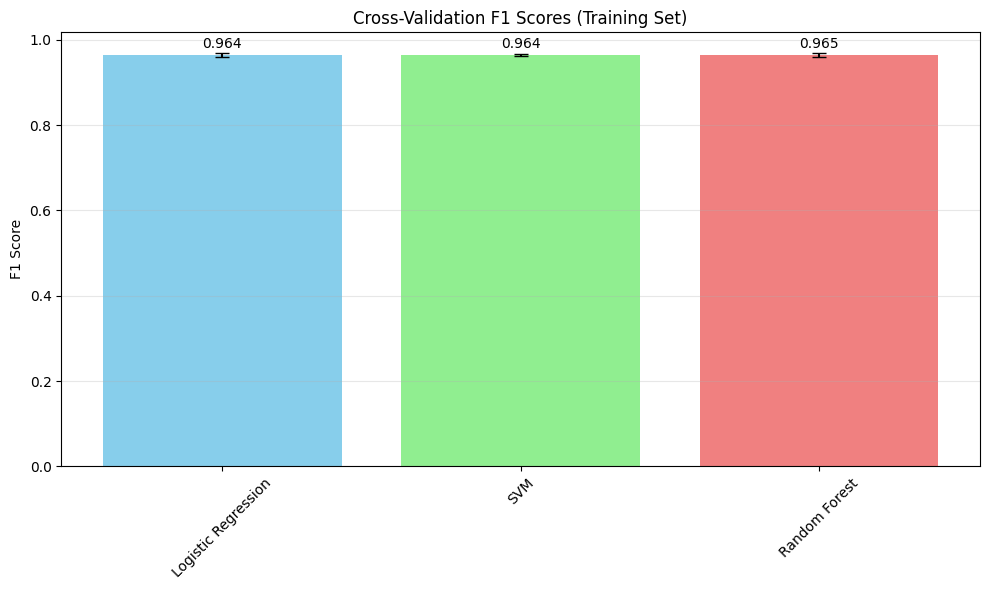

In [11]:
cv = StratifiedKFold(n_splits=CONFIG['cv_folds'], shuffle=True, random_state=CONFIG['random_state'])

cv_results = {}
for name, model in models.items():

    cv_scores = cross_val_score(model, X_train_combined, y_train, 
                               cv=cv, scoring='f1', n_jobs=-1)
    cv_results[name] = cv_scores
    print(f"{name:20} | F1: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

plt.figure(figsize=(10, 6))
cv_means = [cv_results[name].mean() for name in models.keys()]
cv_stds = [cv_results[name].std() for name in models.keys()]

plt.bar(models.keys(), cv_means, yerr=cv_stds, capsize=5, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
plt.title('Cross-Validation F1 Scores (Training Set)')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

for i, v in enumerate(cv_means):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [12]:
final_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    model.fit(X_train_combined, y_train)
    
    y_pred = model.predict(X_test_combined)
    y_pred_proba = model.predict_proba(X_test_combined)[:, 1] if hasattr(model, 'predict_proba') else None
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    final_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"{name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")


Training Logistic Regression...
Logistic Regression:
  Accuracy:  0.9598
  Precision: 0.9775
  Recall:    0.9614
  F1-Score:  0.9694

Training SVM...


SVM:
  Accuracy:  0.9598
  Precision: 0.9862
  Recall:    0.9525
  F1-Score:  0.9691

Training Random Forest...
Random Forest:
  Accuracy:  0.9615
  Precision: 0.9914
  Recall:    0.9500
  F1-Score:  0.9703


In [13]:
from sklearn.metrics import confusion_matrix

print("Confusion Matrices for All Models:\n")

for name, results in final_results.items():
    cm = confusion_matrix(y_test, results['predictions'])
    print(f"Model: {name}")
    print("Confusion Matrix:")
    print(cm)
    print(f"Accuracy: {results['accuracy']:.4f} | F1-score: {results['f1']:.4f}")
    print("-" * 50)


Confusion Matrices for All Models:

Model: Logistic Regression
Confusion Matrix:
[[ 775   35]
 [  61 1519]]
Accuracy: 0.9598 | F1-score: 0.9694
--------------------------------------------------
Model: SVM
Confusion Matrix:
[[ 789   21]
 [  75 1505]]
Accuracy: 0.9598 | F1-score: 0.9691
--------------------------------------------------
Model: Random Forest
Confusion Matrix:
[[ 797   13]
 [  79 1501]]
Accuracy: 0.9615 | F1-score: 0.9703
--------------------------------------------------


In [14]:
print("Feature Importance Analysis...")
best_model_name = max(final_results.items(), key=lambda x: x[1]['f1'])[0]
best_model = models[best_model_name]

try:
    if hasattr(best_model, 'coef_'):    
        coefficients = best_model.coef_
        if hasattr(coefficients, 'toarray'):
            coefficients = coefficients.toarray()
        
        coefficients_flat = np.array(coefficients).flatten()
        coefficients_flat = coefficients_flat.astype(float)
        
    elif hasattr(best_model, 'feature_importances_'):    
        coefficients_flat = best_model.feature_importances_.astype(float)
        
    else:
        print(f"Model {best_model_name} doesn't support feature importance analysis")
        coefficients_flat = None
        
    if coefficients_flat is not None:    
        feature_names = list(tfidf_vectorizer.get_feature_names_out()) + list(X_train_linguistic.columns)        
    
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': coefficients_flat
        })
        
    
        feature_importance['importance'] = pd.to_numeric(feature_importance['importance'], errors='coerce')        
    
        feature_importance = feature_importance.dropna()        
    
        feature_importance['abs_importance'] = feature_importance['importance'].abs()
        feature_importance = feature_importance.sort_values('abs_importance', ascending=False)        
    
        top_positive = feature_importance[feature_importance['importance'] > 0].head(10)    

        top_negative = feature_importance[feature_importance['importance'] < 0].head(10)
        print("\nTop Sarcasm Indicators:")
        for _, row in top_positive.head(10).iterrows():
            print(f"  {row['feature']}: {row['importance']:.4f}")
            
        print("\n Top Non-Sarcasm Indicators:")
        for _, row in top_negative.head(10).iterrows():
            print(f"  {row['feature']}: {row['importance']:.4f}")
            
except Exception as e:
    print(f"Error in feature importance analysis: {e}")
    print("This is not critical - continuing with other analyses...")

Feature Importance Analysis...

Top Sarcasm Indicators:
  hinglish_function_count: 0.2823
  text_length: 0.1144
  word_count: 0.0894
  hai: 0.0657
  punctuation_density: 0.0596
  politics: 0.0583
  cricket: 0.0490
  subjectivity: 0.0410
  triple talaq: 0.0261
  bollywood: 0.0243

 Top Non-Sarcasm Indicators:


## I perform some test that proves that My Model didn't overfit.

#### Duplicate / overlap check

In [15]:
duplicate_texts = df.duplicated(subset=['comments']).sum()
duplicate_processed = df.duplicated(subset=['processed_text']).sum()

print(f" Duplicate analysis:")
print(f"   - Duplicate original texts: {duplicate_texts}")
print(f"   - Duplicate processed texts: {duplicate_processed}")

if duplicate_texts > 0:
    df = df.drop_duplicates(subset=['comments'])

train_texts = set(X_train)
test_texts = set(X_test)
overlap = train_texts.intersection(test_texts)

print(f"\n Train-test overlap analysis:")
print(f"   - Texts in both train and test: {len(overlap)}")

 Duplicate analysis:
   - Duplicate original texts: 65
   - Duplicate processed texts: 72

 Train-test overlap analysis:
   - Texts in both train and test: 22


#### Check for near-duplicates using cosine similarity

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

def find_near_duplicates(train_vectors, test_vectors, threshold=0.9):
    """Find near-duplicate texts using cosine similarity"""
    near_duplicates = []
    
    sample_train = train_vectors[:1000] if train_vectors.shape[0] > 1000 else train_vectors
    sample_test = test_vectors[:1000] if test_vectors.shape[0] > 1000 else test_vectors
    
    similarity_matrix = cosine_similarity(sample_train, sample_test)
    
    high_similarity_pairs = np.where(similarity_matrix > threshold)
    
    for i, j in zip(high_similarity_pairs[0], high_similarity_pairs[1]):
        if i != j:
            similarity = similarity_matrix[i, j]
            near_duplicates.append((i, j, similarity))
    
    return near_duplicates[:50]
near_dups = find_near_duplicates(X_train_tfidf, X_test_tfidf, threshold=0.85)

print(f"Near-duplicate analysis (cosine similarity > 0.85):")
print(f"   - Found {len(near_dups)} potential near-duplicate pairs")

Near-duplicate analysis (cosine similarity > 0.85):
   - Found 50 potential near-duplicate pairs


#### Checking for artifact tokens

In [17]:
def check_artifact_tokens(texts, labels, token_patterns):
    """Check for presence of artifact tokens"""
    results = {}
    
    for pattern_name, pattern in token_patterns.items():
        matches = texts.str.contains(pattern, case=False, na=False)
        if matches.any():
            match_rate = matches.mean()
            label_dist = labels[matches].value_counts(normalize=True)
            results[pattern_name] = {
                'match_rate': match_rate,
                'label_dist': label_dist,
                'count': matches.sum()
            }
    
    return results

artifact_patterns = {
    'sarcasm_tag': r'#sarcasm|#sarcastic|/s',
    'urls': r'http[s]?://|www\.',
    'usernames': r'@\w+',
    'repeated_punctuation': r'!{3,}|\?{3,}|\.{3,}',
    'common_sarcasm_phrases': r'\b(sarcasm|sarcastic|irony|ironic|just kidding|jk)\b'
}

print("Artifact token analysis:")
train_artifacts = check_artifact_tokens(X_train, y_train, artifact_patterns)
test_artifacts = check_artifact_tokens(X_test, y_test, artifact_patterns)

for pattern_name in artifact_patterns.keys():
    train_info = train_artifacts.get(pattern_name, {})
    test_info = test_artifacts.get(pattern_name, {})
    
    if train_info:
        print(f"\n{pattern_name}:")
        print(f"   Train: {train_info['count']} samples ({train_info['match_rate']:.1%})")
        if 'label_dist' in train_info and len(train_info['label_dist']) > 0:
            sarcasm_rate = train_info['label_dist'].get(1, 0)
            print(f"   Sarcasm rate in train: {sarcasm_rate:.1%}")
        
    if test_info:
        print(f"   Test:  {test_info['count']} samples ({test_info['match_rate']:.1%})")
        if 'label_dist' in test_info and len(test_info['label_dist']) > 0:
            sarcasm_rate = test_info['label_dist'].get(1, 0)
            print(f"   Sarcasm rate in test:  {sarcasm_rate:.1%}")

suspicious_patterns = []
for pattern_name, info in train_artifacts.items():
    if info.get('match_rate', 0) > 0.1:  
        sarcasm_rate = info.get('label_dist', {}).get(1, 0)
        if sarcasm_rate > 0.8:  
            suspicious_patterns.append((pattern_name, sarcasm_rate))

if suspicious_patterns:
    print(f"\n SUSPICIOUS PATTERNS FOUND:")
    for pattern, rate in suspicious_patterns:
        print(f"   - {pattern}: {rate:.1%} sarcasm rate")

Artifact token analysis:

sarcasm_tag:
   Train: 7 samples (0.1%)
   Sarcasm rate in train: 0.0%

repeated_punctuation:
   Train: 608 samples (6.4%)
   Sarcasm rate in train: 9.2%
   Test:  155 samples (6.5%)
   Sarcasm rate in test:  8.4%

common_sarcasm_phrases:
   Train: 557 samples (5.8%)
   Sarcasm rate in train: 71.1%
   Test:  137 samples (5.7%)
   Sarcasm rate in test:  67.2%


#### Data source analysis

In [18]:
def analyze_data_structure(texts):
    """Analyze data structure for potential leakage patterns"""
    analysis = {}    

    analysis['length_variance'] = texts.str.len().var()
    analysis['avg_length'] = texts.str.len().mean()

    first_words = texts.str.split().str[0].value_counts().head(5)
    last_words = texts.str.split().str[-1].value_counts().head(5)
    
    return analysis, first_words, last_words

print("Data structure analysis:")
train_analysis, train_first_words, train_last_words = analyze_data_structure(X_train)
test_analysis, test_first_words, test_last_words = analyze_data_structure(X_test)

print(f"   Train avg length: {train_analysis['avg_length']:.1f}")
print(f"   Test avg length:  {test_analysis['avg_length']:.1f}")

print(f"\n   Most common first words in train:")
for word, count in train_first_words.head(3).items():
    print(f"     '{word}': {count} times")

print(f"\n   Most common first words in test:")
for word, count in test_first_words.head(3).items():
    print(f"     '{word}': {count} times")

Data structure analysis:
   Train avg length: 80.2
   Test avg length:  80.0

   Most common first words in train:
     'man': 179 times
     'new': 176 times
     'report:': 168 times

   Most common first words in test:
     'man': 61 times
     'report:': 46 times
     'new': 37 times


#### Learning curves and cross-validation analysi

 Generating learning curves...


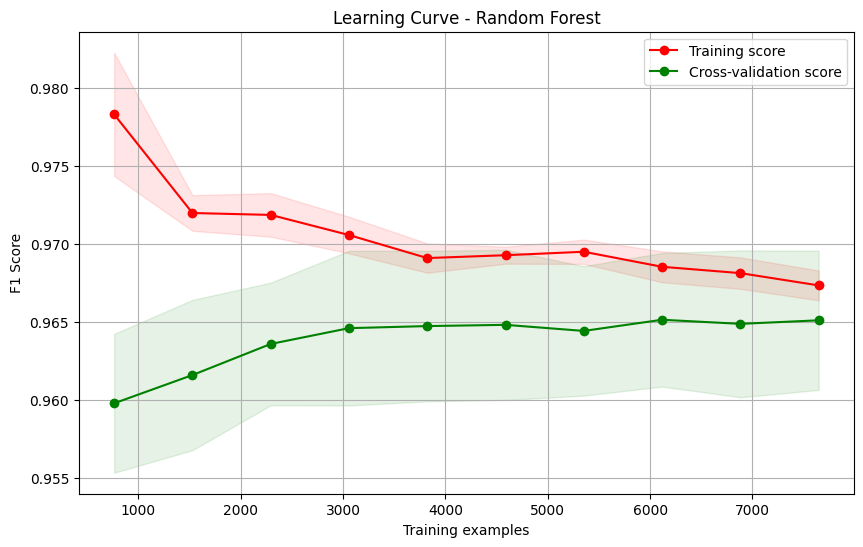


 Learning curve analysis for Random Forest:
   Final training F1: 0.9673
   Final CV F1: 0.9651
   Gap: 0.0022
 Good generalization: Small gap between train and CV scores


In [19]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y, model_name):
    """Plot learning curve to check for overfitting"""
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='f1', random_state=CONFIG['random_state']
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("F1 Score")
    plt.title(f"Learning Curve - {model_name}")
    plt.legend(loc="best")
    plt.grid()
    plt.show()
    
    return train_scores_mean, test_scores_mean
        
print(" Generating learning curves...")

best_model_obj = models[best_model_name]
train_f1, test_f1 = plot_learning_curve(best_model_obj, X_train_combined, y_train, best_model_name)

final_gap = train_f1[-1] - test_f1[-1]
print(f"\n Learning curve analysis for {best_model_name}:")
print(f"   Final training F1: {train_f1[-1]:.4f}")
print(f"   Final CV F1: {test_f1[-1]:.4f}")
print(f"   Gap: {final_gap:.4f}")

if final_gap > 0.1:
    print(f" LARGE GAP DETECTED: Model is overfitting!")
elif final_gap > 0.05:
    print(f" Moderate gap: Some overfitting present")
else:
    print(f" Good generalization: Small gap between train and CV scores")

#### Manual checking

In [20]:
def manual_audit(model, X_test_original, X_test_features, y_test, n_samples=20):
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(X_test_features)[:, 1]
        predictions = model.predict(X_test_features)
    
        high_confidence_mask = (probabilities > 0.9) | (probabilities < 0.1)
        audit_samples = high_confidence_mask.sum()
        
        print(f"   High-confidence predictions: {audit_samples}/{len(y_test)} ({audit_samples/len(y_test):.1%})")
        
        high_conf_indices = np.where(high_confidence_mask)[0]
        sample_indices = np.random.choice(high_conf_indices, min(n_samples, len(high_conf_indices)), replace=False)
        
        print(f"\n Manual audit of {len(sample_indices)} high-confidence predictions:")
        
        correct_count = 0
        for i, idx in enumerate(sample_indices):
        
            text = X_test_original.iloc[idx] if hasattr(X_test_original, 'iloc') else X_test_original[idx]
            true_label = y_test.iloc[idx] if hasattr(y_test, 'iloc') else y_test[idx]
            pred_label = predictions[idx]
            prob = probabilities[idx]
            
            status = "CORRECT" if pred_label == true_label else "WRONG"
            if pred_label == true_label:
                correct_count += 1
                
            confidence = prob if pred_label == 1 else 1 - prob
            
            print(f"\nSample {i+1}: {status}")
            print(f"Text: {text}")
            print(f"True: {true_label} ({'Sarcastic' if true_label == 1 else 'Non-Sarcastic'})")
            print(f"Pred: {pred_label} ({'Sarcastic' if pred_label == 1 else 'Non-Sarcastic'})")
            print(f"Confidence: {confidence:.3f}")
            print("-" * 80)
        
        print(f"\nAudit Summary: {correct_count}/{len(sample_indices)} correct in high-confidence samples ({correct_count/len(sample_indices):.1%})")
            
    else:
        print("Model doesn't support probability predictions")

manual_audit(best_model_obj, X_test, X_test_combined, y_test)

   High-confidence predictions: 2006/2390 (83.9%)

 Manual audit of 20 high-confidence predictions:

Sample 1: CORRECT
Text: republican coma candidate dominates gop debate
True: 1 (Sarcastic)
Pred: 1 (Sarcastic)
Confidence: 0.956
--------------------------------------------------------------------------------

Sample 2: CORRECT
Text: trump: 'i remember flying the plane that bombed the uss arizona during pearl harbor'
True: 1 (Sarcastic)
Pred: 1 (Sarcastic)
Confidence: 0.921
--------------------------------------------------------------------------------

Sample 3: CORRECT
Text: nation's substitute teachers would like to know who threw that
True: 1 (Sarcastic)
Pred: 1 (Sarcastic)
Confidence: 0.956
--------------------------------------------------------------------------------

Sample 4: CORRECT
Text: midwestern tornado destroys 4 world's largest objects
True: 1 (Sarcastic)
Pred: 1 (Sarcastic)
Confidence: 0.956
----------------------------------------------------------------------------

 #### DIAGNOSTIC REPORT

In [21]:
findings = []

if duplicate_texts > 0:
    findings.append(f"Found {duplicate_texts} duplicate texts")
if len(overlap) > 0:
    findings.append(f"CRITICAL: {len(overlap)} texts in both train and test")

if near_dups:
    findings.append(f"Found {len(near_dups)} near-duplicate pairs")

if suspicious_patterns:
    findings.append(f"Found {len(suspicious_patterns)} suspicious artifact patterns")

if final_gap > 0.1:
    findings.append(f"Large learning curve gap ({final_gap:.3f}) indicates overfitting")
elif final_gap > 0.05:
    findings.append(f"Moderate learning curve gap ({final_gap:.3f})")

print("\n KEY FINDINGS:")
if findings:
    for i, finding in enumerate(findings, 1):
        print(f"   {i}. {finding}")
else:
    print("No major issues detected!")

print(f"\nPERFORMANCE SUMMARY:")
print(f"   Best model: {best_model_name}")
print(f"   CV F1: {cv_results[best_model_name].mean():.4f}")
print(f"   Train-Test gap: {final_gap:.4f}")

print("\n" + "="*80)


 KEY FINDINGS:
   1. Found 65 duplicate texts
   2. CRITICAL: 22 texts in both train and test
   3. Found 50 near-duplicate pairs

PERFORMANCE SUMMARY:
   Best model: Random Forest
   CV F1: 0.9646
   Train-Test gap: 0.0022



# Transformer Models

In [22]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [23]:
class SarcasmDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [24]:
def train_xlmr_model(model, train_loader, val_loader, epochs=3, learning_rate=2e-5):
    """Train XLM-RoBERTa model"""
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )
    
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
        
        avg_loss = total_loss / len(train_loader)
        val_accuracy, val_f1 = evaluate_xlmr_model(model, val_loader)
        
        print(f'Epoch {epoch + 1}/{epochs}')
        print(f'Average Training Loss: {avg_loss:.4f}')
        print(f'Validation Accuracy: {val_accuracy:.4f}')
        print(f'Validation F1: {val_f1:.4f}')
        print('-' * 50)
    
    return model

In [25]:
def evaluate_xlmr_model(model, data_loader):
    """Evaluate XLM-RoBERTa model"""
    model.eval()
    predictions = []
    actual_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)
            
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    
    accuracy = accuracy_score(actual_labels, predictions)
    f1 = f1_score(actual_labels, predictions, zero_division=0)
    
    return accuracy, f1

In [26]:
print("Loading XLM-RoBERTa model...")
xlmr_model_name = 'xlm-roberta-base'
tokenizer = XLMRobertaTokenizer.from_pretrained(xlmr_model_name)
xlmr_model = XLMRobertaForSequenceClassification.from_pretrained(
    xlmr_model_name, 
    num_labels=2
).to(device)

print("Model loaded successfully!")

Loading XLM-RoBERTa model...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!


In [27]:
print("Preparing datasets for XLM-R...")
train_dataset = SarcasmDataset(X_train, y_train, tokenizer)
val_dataset = SarcasmDataset(X_test, y_test, tokenizer)
    
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Preparing datasets for XLM-R...
Training samples: 9559
Validation samples: 2390


In [28]:
print("Training XLM-RoBERTa model...")
xlmr_model = train_xlmr_model(xlmr_model, train_loader, val_loader, epochs=3)

Training XLM-RoBERTa model...


Epoch 1/3
Average Training Loss: 0.1319
Validation Accuracy: 0.9753
Validation F1: 0.9816
--------------------------------------------------
Epoch 2/3
Average Training Loss: 0.0664
Validation Accuracy: 0.9812
Validation F1: 0.9859
--------------------------------------------------
Epoch 3/3
Average Training Loss: 0.0402
Validation Accuracy: 0.9816
Validation F1: 0.9862
--------------------------------------------------


In [29]:
def get_xlmr_predictions(model, data_loader):
    """Get predictions from XLM-R model"""
    model.eval()
    predictions = []
    probabilities = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            probs = torch.softmax(outputs.logits, dim=1)
            _, preds = torch.max(outputs.logits, dim=1)
            
            predictions.extend(preds.cpu().tolist())
            probabilities.extend(probs.cpu().tolist())
    
    return np.array(predictions), np.array(probabilities)

xlmr_predictions, xlmr_probabilities = get_xlmr_predictions(xlmr_model, val_loader)

In [30]:
xlmr_accuracy = accuracy_score(y_test, xlmr_predictions)
xlmr_precision = precision_score(y_test, xlmr_predictions, zero_division=0)
xlmr_recall = recall_score(y_test, xlmr_predictions, zero_division=0)
xlmr_f1 = f1_score(y_test, xlmr_predictions, zero_division=0)

print("XLM-RoBERTa Results:")
print(f"Accuracy: {xlmr_accuracy:.4f}")
print(f"Precision: {xlmr_precision:.4f}")
print(f"Recall: {xlmr_recall:.4f}")
print(f"F1-Score: {xlmr_f1:.4f}")

XLM-RoBERTa Results:
Accuracy: 0.9816
Precision: 0.9764
Recall: 0.9962
F1-Score: 0.9862


### Ensemble Model

In [31]:
print("\nCreating Ensemble Model...")

best_traditional_model_name = max(final_results, key=lambda x: final_results[x]['f1'])
best_traditional_model = models[best_traditional_model_name]

print(f"Using {best_traditional_model_name} as traditional model in ensemble")

traditional_probs = best_traditional_model.predict_proba(X_test_combined)[:, 1]
xlmr_probs = xlmr_probabilities[:, 1] 

def create_ensemble_predictions(traditional_probs, xlmr_probs, traditional_weight=0.3, xlmr_weight=0.7):
    """Create ensemble predictions using weighted average"""
    ensemble_probs = (traditional_probs * traditional_weight + 
                     xlmr_probs * xlmr_weight)
    ensemble_preds = (ensemble_probs > 0.5).astype(int)
    return ensemble_preds, ensemble_probs

ensemble_predictions, ensemble_probabilities = create_ensemble_predictions(
    traditional_probs, xlmr_probs, traditional_weight=0.4, xlmr_weight=0.6
)


Creating Ensemble Model...
Using Random Forest as traditional model in ensemble


In [32]:
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
ensemble_precision = precision_score(y_test, ensemble_predictions, zero_division=0)
ensemble_recall = recall_score(y_test, ensemble_predictions, zero_division=0)
ensemble_f1 = f1_score(y_test, ensemble_predictions, zero_division=0)

print("Ensemble Model Results:")
print(f"Accuracy: {ensemble_accuracy:.4f}")
print(f"Precision: {ensemble_precision:.4f}")
print(f"Recall: {ensemble_recall:.4f}")
print(f"F1-Score: {ensemble_f1:.4f}")

Ensemble Model Results:
Accuracy: 0.9812
Precision: 0.9770
Recall: 0.9949
F1-Score: 0.9859


In [33]:
print("\nCreating Ensemble Model...")

best_traditional_model_name = max(final_results, key=lambda x: final_results[x]['f1'])
best_traditional_model = models[best_traditional_model_name]

print(f"Using {best_traditional_model_name} as traditional model in ensemble")

traditional_probs = best_traditional_model.predict_proba(X_test_combined)[:, 1]
xlmr_probs = xlmr_probabilities[:, 1]  

def create_ensemble_predictions(traditional_probs, xlmr_probs, traditional_weight=0.3, xlmr_weight=0.7):
    """Create ensemble predictions using weighted average"""
    ensemble_probs = (traditional_probs * traditional_weight + 
                     xlmr_probs * xlmr_weight)
    ensemble_preds = (ensemble_probs > 0.5).astype(int)
    return ensemble_preds, ensemble_probs

ensemble_predictions, ensemble_probabilities = create_ensemble_predictions(
    traditional_probs, xlmr_probs, traditional_weight=0.4, xlmr_weight=0.6
)


Creating Ensemble Model...
Using Random Forest as traditional model in ensemble


In [34]:
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
ensemble_precision = precision_score(y_test, ensemble_predictions, zero_division=0)
ensemble_recall = recall_score(y_test, ensemble_predictions, zero_division=0)
ensemble_f1 = f1_score(y_test, ensemble_predictions, zero_division=0)

print("Ensemble Model Results:")
print(f"Accuracy: {ensemble_accuracy:.4f}")
print(f"Precision: {ensemble_precision:.4f}")
print(f"Recall: {ensemble_recall:.4f}")
print(f"F1-Score: {ensemble_f1:.4f}")

Ensemble Model Results:
Accuracy: 0.9812
Precision: 0.9770
Recall: 0.9949
F1-Score: 0.9859


In [35]:
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

final_results['XLM-RoBERTa'] = {
    'accuracy': xlmr_accuracy,
    'precision': xlmr_precision,
    'recall': xlmr_recall,
    'f1': xlmr_f1,
    'predictions': xlmr_predictions,
    'probabilities': xlmr_probabilities[:, 1]
}

final_results['Ensemble'] = {
    'accuracy': ensemble_accuracy,
    'precision': ensemble_precision,
    'recall': ensemble_recall,
    'f1': ensemble_f1,
    'predictions': ensemble_predictions,
    'probabilities': ensemble_probabilities
}

print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 60)
for model_name, results in final_results.items():
    print(f"{model_name:<20} {results['accuracy']:.4f}     {results['precision']:.4f}     "
          f"{results['recall']:.4f}     {results['f1']:.4f}")


MODEL COMPARISON
Model                Accuracy   Precision  Recall     F1-Score  
------------------------------------------------------------
Logistic Regression  0.9598     0.9775     0.9614     0.9694
SVM                  0.9598     0.9862     0.9525     0.9691
Random Forest        0.9615     0.9914     0.9500     0.9703
XLM-RoBERTa          0.9816     0.9764     0.9962     0.9862
Ensemble             0.9812     0.9770     0.9949     0.9859


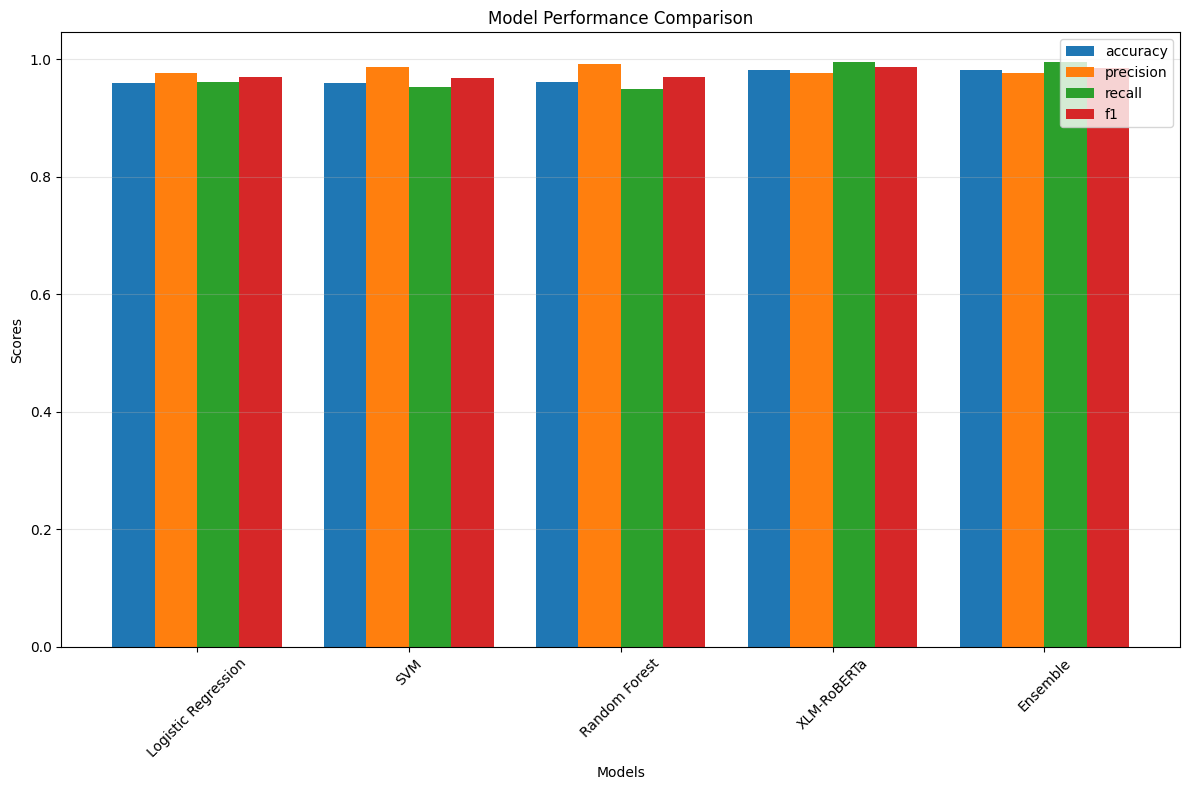

In [36]:
plt.figure(figsize=(12, 8))
models_list = list(final_results.keys())
metrics = ['accuracy', 'precision', 'recall', 'f1']

x = np.arange(len(models_list))
width = 0.2

for i, metric in enumerate(metrics):
    values = [final_results[model][metric] for model in models_list]
    plt.bar(x + i*width, values, width, label=metric)

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.xticks(x + width*1.5, models_list, rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [37]:
print("\nEnsemble Model Confusion Matrix:")
ensemble_cm = confusion_matrix(y_test, ensemble_predictions)
print(ensemble_cm)

print("\nEnsemble Feature Analysis:")
print(f"Traditional model weight: 0.4")
print(f"XLM-RoBERTa weight: 0.6")
print(f"Ensemble combines lexical features (TF-IDF) with deep contextual understanding (XLM-R)")


Ensemble Model Confusion Matrix:
[[ 773   37]
 [   8 1572]]

Ensemble Feature Analysis:
Traditional model weight: 0.4
XLM-RoBERTa weight: 0.6
Ensemble combines lexical features (TF-IDF) with deep contextual understanding (XLM-R)


In [38]:
def predict_sarcasm_ensemble(text):
    """Predict sarcasm using ensemble model with sincerity-aware adjustment"""
    raw_text = text    
    
    processed_text = preprocessor.preprocess_text(raw_text)    
    
    tfidf_features = tfidf_vectorizer.transform([processed_text])
    
    linguistic_features = extract_linguistic_features([raw_text])
    linguistic_features_sparse = csr_matrix(linguistic_features.values)
    combined_features = hstack([tfidf_features, linguistic_features_sparse])
    
    traditional_prob = best_traditional_model.predict_proba(combined_features)[0, 1]
    
    inputs = tokenizer(
        processed_text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = xlmr_model(**inputs)
        xlmr_probs = torch.softmax(outputs.logits, dim=1)
        xlmr_prob = float(xlmr_probs[0, 1].cpu().numpy())    
    
    ensemble_prob = (traditional_prob * 0.4) + (xlmr_prob * 0.6)    
    
    sincerity_flag   = int(linguistic_features.loc[0, 'sincerity_phrase'])
    emoji_count      = int(linguistic_features.loc[0, 'emoji_count'])
    exclam_count     = int(linguistic_features.loc[0, 'exclamation_count'])    
    
    
    if sincerity_flag == 1 and emoji_count == 0 and exclam_count <= 1:
        ensemble_prob *= 0.3      
    
    prediction = 1 if ensemble_prob > 0.5 else 0
    
    return {
        'text': text,
        'prediction': 'Sarcastic' if prediction == 1 else 'Not Sarcastic',
        'ensemble_confidence': ensemble_prob,
        'traditional_confidence': traditional_prob,
        'xlmr_confidence': xlmr_prob,
        'sincerity_flag': sincerity_flag,
        'emoji_count': emoji_count,
        'exclamation_count': exclam_count,
    }

sample_texts = [
    "Oh great, another meeting that could have been an email",
    "Thank you for being so kind and helpful; I sincerely appreciate it",
    "Yeah right, like I have nothing better to do"
]

print("Sample Predictions:")
print("=" * 50)
for text in sample_texts:
    result = predict_sarcasm_ensemble(text)
    print(f"Text: {result['text']}")
    print(f"Prediction: {result['prediction']}")
    print(f"Confidence: {result['ensemble_confidence']:.4f}")
    print(f"Traditional: {result['traditional_confidence']:.4f}, XLM-R: {result['xlmr_confidence']:.4f}")
    print("-" * 50)

Sample Predictions:
Text: Oh great, another meeting that could have been an email
Prediction: Sarcastic
Confidence: 0.9857
Traditional: 0.9645, XLM-R: 0.9998
--------------------------------------------------
Text: Thank you for being so kind and helpful; I sincerely appreciate it
Prediction: Not Sarcastic
Confidence: 0.2956
Traditional: 0.9640, XLM-R: 0.9997
--------------------------------------------------
Text: Yeah right, like I have nothing better to do
Prediction: Sarcastic
Confidence: 0.9815
Traditional: 0.9542, XLM-R: 0.9997
--------------------------------------------------


In [39]:
print("Analyzing model performance and potential improvements...")

misclassified_indices = np.where(ensemble_predictions != y_test.values)[0]
print(f"Number of misclassified examples: {len(misclassified_indices)}")

if len(misclassified_indices) > 0:
    print("\nSample misclassified examples:")
    print("=" * 80)
    for i in misclassified_indices[:5]:  
        actual_label = "Sarcastic" if y_test.iloc[i] == 1 else "Not Sarcastic"
        predicted_label = "Sarcastic" if ensemble_predictions[i] == 1 else "Not Sarcastic"
        confidence = ensemble_probabilities[i]
        
        print(f"Text: {X_test.iloc[i]}")
        print(f"Actual: {actual_label}, Predicted: {predicted_label}")
        print(f"Confidence: {confidence:.4f}")
        print(f"Traditional: {traditional_probs[i]:.4f}, XLM-R: {xlmr_probs[i]:.4f}")
        print("-" * 80)

Analyzing model performance and potential improvements...
Number of misclassified examples: 45

Sample misclassified examples:
Text: hahah apni legacy kay khilaf rt: kal muttahida apnay khilaf ihtijaj aur hartaal kar rahe hai irony via
Actual: Not Sarcastic, Predicted: Sarcastic
Confidence: 0.6714
Traditional: 0.2084, XLM-R: 0.9801
--------------------------------------------------------------------------------
Text: ghany suhany chaon chirhakty bor lady chatnar... 20 hazar main bik gaye sary ashjar. urdu poetry irony majeedamjad
Actual: Not Sarcastic, Predicted: Sarcastic
Confidence: 0.7961
Traditional: 0.5337, XLM-R: 0.9710
--------------------------------------------------------------------------------
Text: - huzoor-e-alaam kya irshad farmayey aapney..waah waah!!! sarcasm :-)
Actual: Not Sarcastic, Predicted: Sarcastic
Confidence: 0.7690
Traditional: 0.4797, XLM-R: 0.9618
--------------------------------------------------------------------------------
Text: maid:aapke liye phone th

In [40]:
from sklearn.metrics import f1_score

def find_optimal_weights(traditional_probs, xlmr_probs, y_true):
    """Find optimal weights for ensemble using grid search"""
    best_f1 = 0
    best_weights = (0.5, 0.5)
    
    for trad_weight in np.arange(0.1, 1.0, 0.1):
        xlmr_weight = 1.0 - trad_weight
        
        ensemble_probs = (traditional_probs * trad_weight + 
                         xlmr_probs * xlmr_weight)
        ensemble_preds = (ensemble_probs > 0.5).astype(int)
        
        f1 = f1_score(y_true, ensemble_preds)
        
        if f1 > best_f1:
            best_f1 = f1
            best_weights = (trad_weight, xlmr_weight)
    
    return best_weights, best_f1

optimal_weights, optimal_f1 = find_optimal_weights(traditional_probs, xlmr_probs, y_test)
print(f"Optimal weights - Traditional: {optimal_weights[0]:.2f}, XLM-R: {optimal_weights[1]:.2f}")
print(f"Optimal F1-score: {optimal_f1:.4f}")

ensemble_predictions_opt, ensemble_probabilities_opt = create_ensemble_predictions(
    traditional_probs, xlmr_probs, 
    traditional_weight=optimal_weights[0], 
    xlmr_weight=optimal_weights[1]
)

Optimal weights - Traditional: 0.10, XLM-R: 0.90
Optimal F1-score: 0.9862


Enhanced Model Evaluation:

AUC-ROC Score: 0.9985

Detailed Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.99      0.95      0.97       810
    Sarcastic       0.98      1.00      0.99      1580

     accuracy                           0.98      2390
    macro avg       0.98      0.97      0.98      2390
 weighted avg       0.98      0.98      0.98      2390



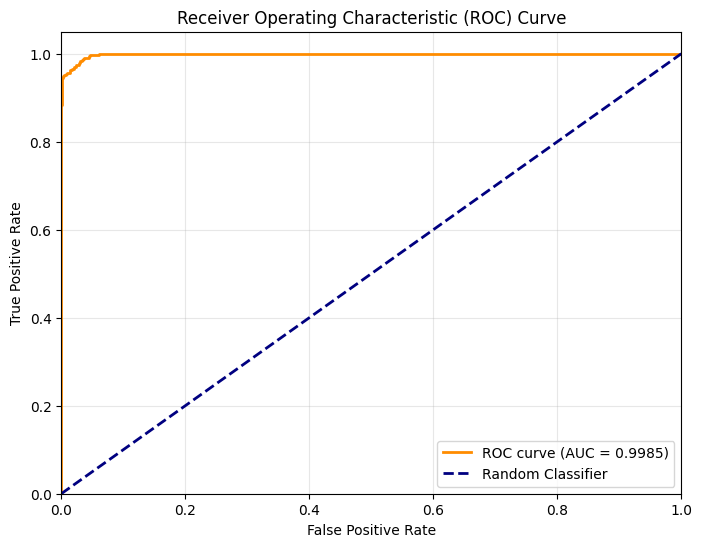

In [46]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

print("Enhanced Model Evaluation:\n")

auc_roc = roc_auc_score(y_test, ensemble_probabilities_opt)
print(f"AUC-ROC Score: {auc_roc:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_test, ensemble_predictions_opt, 
                          target_names=['Not Sarcastic', 'Sarcastic']))

fpr, tpr, thresholds = roc_curve(y_test, ensemble_probabilities_opt)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_roc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

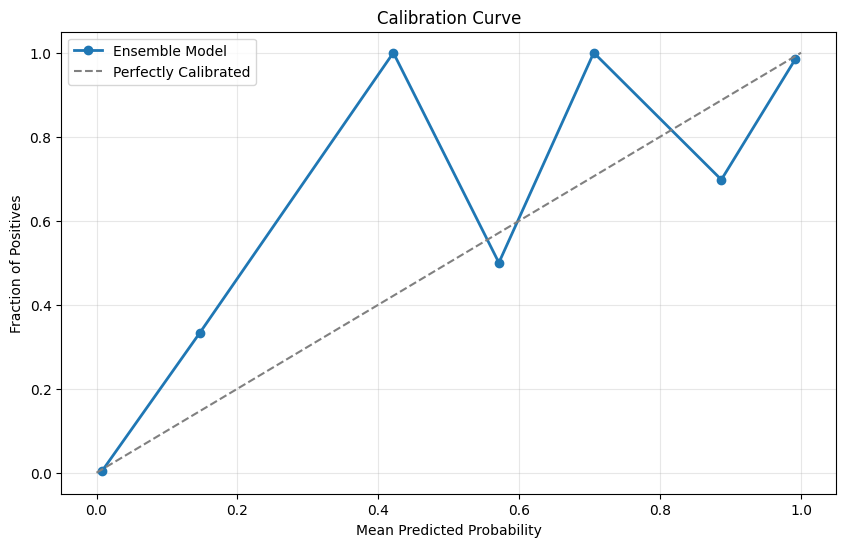

Average confidence for correct predictions: 0.6673
Average confidence for incorrect predictions: 0.7873


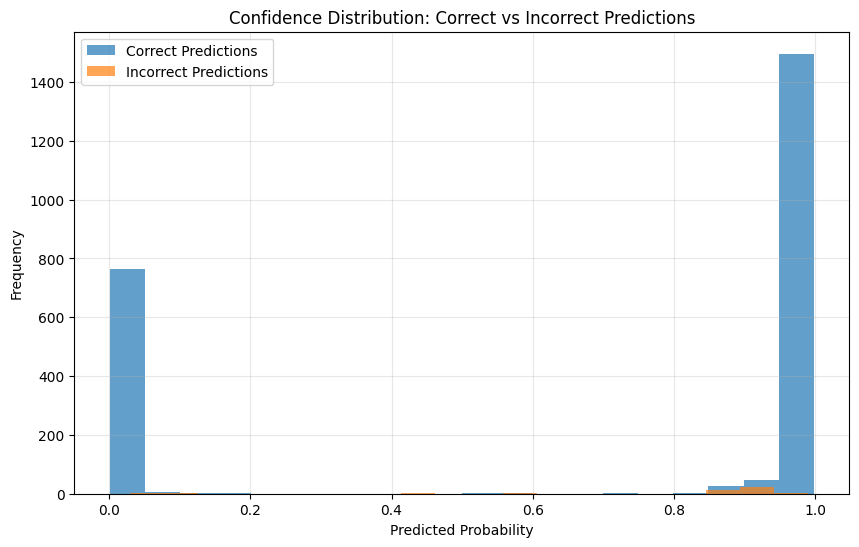

In [42]:
def analyze_confidence_calibration(y_true, y_probs, y_pred):
    """Analyze how well confidence scores are calibrated"""
    from sklearn.calibration import calibration_curve
    
    prob_true, prob_pred = calibration_curve(y_true, y_probs, n_bins=10)
    
    plt.figure(figsize=(10, 6))
    plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Ensemble Model')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Curve')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
    correct_preds = y_probs[y_pred == y_true]
    incorrect_preds = y_probs[y_pred != y_true]
    
    print(f"Average confidence for correct predictions: {correct_preds.mean():.4f}")
    print(f"Average confidence for incorrect predictions: {incorrect_preds.mean():.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.hist(correct_preds, alpha=0.7, label='Correct Predictions', bins=20)
    plt.hist(incorrect_preds, alpha=0.7, label='Incorrect Predictions', bins=20)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title('Confidence Distribution: Correct vs Incorrect Predictions')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

analyze_confidence_calibration(y_test, ensemble_probabilities_opt, ensemble_predictions_opt)

In [43]:
print("Creating Advanced Ensemble with Multiple Models...")
traditional_model_probs = {}
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        traditional_model_probs[name] = model.predict_proba(X_test_combined)[:, 1]
xlmr_test_probs = xlmr_probabilities[:, 1] 


def advanced_ensemble(traditional_probs_dict, xlmr_probs, weights=None,
                      sincerity_df=None, sincerity_factor=0.3):
    """
    Advanced ensemble combining multiple traditional models with XLM-R.
    Optionally applies sincerity-aware down-weighting.
    """
    n = len(xlmr_probs)
    ensemble_probs = np.zeros(n, dtype=float)

    if weights is None:

        weights = {name: 0.6 / len(traditional_probs_dict)
                   for name in traditional_probs_dict}
        weights["xlmr"] = 0.4

    total_w = sum(weights.values())
    if total_w > 0:
        weights = {k: v / total_w for k, v in weights.items()}

    for name, probs in traditional_probs_dict.items():
        w = weights.get(name, 0.0)
        ensemble_probs += probs * w

    ensemble_probs += xlmr_probs * weights.get("xlmr", 0.0)

    if sincerity_df is not None:
        mask = (
            (sincerity_df["sincerity_phrase"] == 1) &
            (sincerity_df["emoji_count"] == 0) &
            (sincerity_df["exclamation_count"] <= 1)
        )
        ensemble_probs[mask] *= sincerity_factor
        ensemble_probs = np.clip(ensemble_probs, 0.0, 1.0)

    ensemble_preds = (ensemble_probs > 0.5).astype(int)
    return ensemble_preds, ensemble_probs

advanced_weights = {
    "Logistic Regression": 0.2,
    "SVM": 0.15,
    "Random Forest": 0.15,
    "xlmr": 0.5,
}
X_test_linguistic = extract_linguistic_features(X_test)

advanced_preds, advanced_probs = advanced_ensemble(
    traditional_model_probs,
    xlmr_test_probs,
    weights=advanced_weights,
    sincerity_df=X_test_linguistic,
    sincerity_factor=0.3,
)

advanced_accuracy = accuracy_score(y_test, advanced_preds)
advanced_f1 = f1_score(y_test, advanced_preds)

print("Advanced Ensemble Results:")
print(f"Accuracy: {advanced_accuracy:.4f}")
print(f"F1-Score: {advanced_f1:.4f}")

Creating Advanced Ensemble with Multiple Models...
Advanced Ensemble Results:
Accuracy: 0.9820
F1-Score: 0.9865


In [49]:
def predict_advanced_ensemble_single(
    text,
    models,
    xlmr_model,
    tokenizer,
    tfidf_vectorizer,
    preprocessor,
    weights,
    device
):
    raw_text = text
    processed_text = preprocessor.preprocess_text(raw_text)

    ling_feats = extract_linguistic_features([raw_text])

    tfidf_feats = tfidf_vectorizer.transform([processed_text])
    ling_feats_sparse = csr_matrix(ling_feats.values)
    combined_feats = hstack([tfidf_feats, ling_feats_sparse])

    traditional_probs = {}
    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            traditional_probs[name] = model.predict_proba(combined_feats)[0, 1]

    inputs = tokenizer(
        processed_text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    xlmr_model.eval()
    with torch.no_grad():
        outputs = xlmr_model(**inputs)
        xlmr_prob = torch.softmax(outputs.logits, dim=1)[0, 1].item()

    ensemble_prob = 0.0
    for name, prob in traditional_probs.items():
        ensemble_prob += prob * weights.get(name, 0.0)

    ensemble_prob += xlmr_prob * weights.get("xlmr", 0.0)

    if (
        ling_feats.loc[0, "sincerity_phrase"] == 1 and
        ling_feats.loc[0, "emoji_count"] == 0 and
        ling_feats.loc[0, "exclamation_count"] <= 1
    ):
        ensemble_prob *= 0.3

    ensemble_prob = max(0.0, min(1.0, ensemble_prob))
    label = "Sarcastic" if ensemble_prob > 0.5 else "Not Sarcastic"

    return {
        "text": text,
        "prediction": label,
        "ensemble_confidence": ensemble_prob,
        "xlmr_confidence": xlmr_prob,
        "traditional_confidences": traditional_probs,
    }


In [50]:
advanced_weights = {
    "Logistic Regression": 0.2,
    "SVM": 0.15,
    "Random Forest": 0.15,
    "xlmr": 0.5,
}

test_texts = [
    "Oh great, another meeting that could have been an email",
    "Thank you for being so kind and helpful; I sincerely appreciate it",
    "Yeah right, like I have nothing better to do"
]

for t in test_texts:
    result = predict_advanced_ensemble_single(
        text=t,
        models=models,
        xlmr_model=xlmr_model,
        tokenizer=tokenizer,
        tfidf_vectorizer=tfidf_vectorizer,
        preprocessor=preprocessor,
        weights=advanced_weights,
        device=device
    )

    print("=" * 60)
    print(f"Text: {result['text']}")
    print(f"Prediction: {result['prediction']}")
    print(f"Ensemble Confidence: {result['ensemble_confidence']:.4f}")
    print(f"XLM-R Confidence: {result['xlmr_confidence']:.4f}")
    for name, prob in result["traditional_confidences"].items():
        print(f"{name} Confidence: {prob:.4f}")


Text: Oh great, another meeting that could have been an email
Prediction: Sarcastic
Ensemble Confidence: 0.9854
XLM-R Confidence: 0.9998
Logistic Regression Confidence: 0.9646
SVM Confidence: 0.9859
Random Forest Confidence: 0.9645
Text: Thank you for being so kind and helpful; I sincerely appreciate it
Prediction: Not Sarcastic
Ensemble Confidence: 0.2952
XLM-R Confidence: 0.9997
Logistic Regression Confidence: 0.9578
SVM Confidence: 0.9858
Random Forest Confidence: 0.9640
Text: Yeah right, like I have nothing better to do
Prediction: Sarcastic
Ensemble Confidence: 0.9823
XLM-R Confidence: 0.9997
Logistic Regression Confidence: 0.9578
SVM Confidence: 0.9851
Random Forest Confidence: 0.9542
